[View in Colaboratory](https://colab.research.google.com/github/sungreong/TIL/blob/master/[%EC%99%84%EC%84%B1%EB%B3%B8]Nonparametric_Regression_Homework4.ipynb)

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
cd ./gdrive/My Drive/대학원수업/비모수회귀분석(함수추정)

/content/gdrive/My Drive/대학원수업/비모수회귀분석(함수추정)


# 틀린게 있을 수도 있으니 주의바람.
# FeedBack 주시면 감사하겠습니다.

# 1 .
## The data are the infant-mortality rates (infant death per 1000 live births)
## and GDP per capita (in U.S. dollars) for 193 countries in 2003 . 

* Make a scatter plot of the data
* Estimate the regression function with different approaches.
  Give your comments

In [3]:
import os
print(os.cpu_count())
process = os.cpu_count()

2


In [4]:
import statsmodels.nonparametric.api as nparam
import pandas as pd 
import numpy as np
import math
import matplotlib.pyplot as plt
data = pd.read_csv("https://raw.githubusercontent.com/jgscott/learnR/master/infmort/infmort.csv")
data2 = data.dropna()
data2 = data2.sort_values(by = ["gdp"])
data2.head()

,country,mortality,gdp
175,Sudan,71.0,36.0
161,Sao.Tome,51.0,49.0
128,Mozambique,110.0,77.0
58,Ethiopia,107.0,96.0
56,Eritrea,98.0,96.0


In [0]:
## Kernel Function 모음


def epan( x = None , h =  None) :
    M  =  x[:, None] - x[None, :] 
    M  = M / h 
    index = (M >= -1 )& (M <= 1)
    condition1 = index
    condition2 = np.invert(index)
    M[ condition1 ] = 0.75*(1- np.square(M[condition1] )) 
    M[ condition2 ] = 1e-11
    return M
        
    
def cosine(x = None, h = None) :
    M  = ( x[:, None] - x[None, :] ) 
    M  = M / h 
    index = (M >= -1 ) & (M <= 1)
    condition1 = index
    condition2 = np.invert(index)
    M[ condition1 ] = np.dot(np.cos(np.dot(M[condition1] , np.pi/2  )), np.pi/4 )
    M[ condition2 ] = 1e-11
    
    return M



In [0]:
from math import ceil
import numpy as np
from scipy import linalg


def lowess2(x, y, f=2. / 3., iter=3):
    """lowess(x, y, f=2./3., iter=3) -> yest
    Lowess smoother: Robust locally weighted regression.
    The lowess function fits a nonparametric regression curve to a scatterplot.
    The arrays x and y contain an equal number of elements; each pair
    (x[i], y[i]) defines a data point in the scatterplot. The function returns
    the estimated (smooth) values of y.
    The smoothing span is given by f. A larger value for f will result in a
    smoother curve. The number of robustifying iterations is given by iter. The
    function will run faster with a smaller number of iterations.
    """
    n = len(x)
    r = int(np.ceil(f * n))
    h = [np.sort(np.abs(x - x[i]))[r] for i in range(n)]
    w = np.clip(np.abs((x[:, None] - x[None, :]) / h), 0.0, 1.0)
    w = (1 - w ** 3) ** 3
    yest = np.zeros(n)
    delta = np.ones(n)
    for iteration in range(iter):
        for i in range(n):
            weights = delta * w[:, i]
            b = np.array([np.sum(weights * y), np.sum(weights * y * x)])
            A = np.array([[np.sum(weights), np.sum(weights * x)],
                          [np.sum(weights * x), np.sum(weights * x * x)]])
            beta = linalg.solve(A, b)
            yest[i] = beta[0] + beta[1] * x[i]

        residuals = y - yest
        s = np.median(np.abs(residuals))
        delta = np.clip(residuals / (6.0 * s), -1, 1)
        delta = (1 - delta ** 2) ** 2

    return yest

        


def NWE(X = None ,Y = None , h = None , leave = False , K = "normal") : 
    if K == "normal" :
        matrix = norm.pdf( (X[:, None] - X[None, :]) / h  , loc = 0 ,scale = 1) / h
    elif K == "epa" :
        matrix = epan( X , h ) / h 
    elif K == "cosine" :
        matrix = cosine(  X , h   ) / h 
       
    ## 자기자신을 없앤다는 의미는 곧 자기자신을 0으로 만들면 되지 않을까 싶어서 이렇게 진행함
    if leave == True :
        np.fill_diagonal( matrix , 0 )
    else :
        pass 
    denominator = np.sum( matrix , axis =  1 ) 
    numerator   = np.sum( matrix * Y , axis = 1 ) 
    m_hat = numerator/denominator  
    dataframe = np.concatenate([X[:, np.newaxis ], m_hat[: , np.newaxis ]] , axis = 1 )
    pred = pd.DataFrame( dataframe , columns = ["x", "nw"]).sort_values(by = ["x"])
    return pred


    
def loc_avg(X = None , Y = None , h = None , leave = False ) :
    matrix = (X[:, None] - X[None, :]) / h 
    index = (matrix >= - 1.0 ) & (matrix <= 1.0 ) 
    matrix[index] = 1
    matrix[~index] = 1e-18
    if leave == True :
        np.fill_diagonal( matrix , 0 )
    else :
        pass 
   
    denominator = np.sum(matrix , axis =  1 ) 
    numerator = np.sum(matrix * Y , axis = 1 ) 
    m_hat = numerator/denominator 
    dataframe = np.concatenate([X[:, np.newaxis ], m_hat[: , np.newaxis ]] , axis = 1 )
    pred = pd.DataFrame( dataframe , columns = ["x", "local"]).sort_values(by = ["x"])
    return pred


## Method 
*  local_avg 
* nw 

In [0]:
def CV(X = None , Y= None , h=None , method = None , leave = True , kernel = "normal" ) : 
    if method == "local_avg" :
        output = loc_avg(X , Y , h , leave )
        dataframe = np.concatenate([X[:, np.newaxis ] , Y[: , np.newaxis] ], axis = 1 )
        real = pd.DataFrame( dataframe , columns = ["x" , "true_y"]).sort_values(by = ["x"])
        pred = pd.concat([output , real.true_y ] , axis = 1 )
        AMSE = np.mean( np.square( pred.true_y.values - pred.local.values ) )
    elif method == "nw" :
        output = NWE(X , Y , h  , leave , K = kernel )
        dataframe = np.concatenate([X[:, np.newaxis ] , Y[: , np.newaxis] ], axis = 1 )
        real = pd.DataFrame( dataframe , columns = ["x" , "true_y"]).sort_values(by = ["x"])
        pred = pd.concat([output , real.true_y ] , axis = 1 )
        AMSE = np.mean( np.square( pred.true_y.values - pred.nw.values ) )
    return AMSE



def BASIC_CV(X = None , Y= None , h=None , method = None , kernel = "normal" ) : 
    if method == "local_avg" :
        output = loc_avg(X , Y , h )
        dataframe = np.concatenate([X[:, np.newaxis ] , Y[: , np.newaxis] ], axis = 1 )
        real = pd.DataFrame( dataframe , columns = ["x" , "true_y"]).sort_values(by = ["x"])
        pred = pd.concat([output , real.true_y ] , axis = 1 )
        AMSE = np.mean( np.square( pred.true_y.values - pred.local.values ) )
    elif method == "nw" :
        output = NWE(X , Y , h , K = kernel)
        dataframe = np.concatenate([X[:, np.newaxis ] , Y[: , np.newaxis] ], axis = 1 )
        real = pd.DataFrame( dataframe , columns = ["x" , "true_y"]).sort_values(by = ["x"])
        pred = pd.concat([output , real.true_y ] , axis = 1 )
        value_ = [  pred.true_y.values[i]- pred.nw.values[i]   for i in np.arange(len(pred))]
        AMSE = np.mean( np.square( value_ ) )
    return AMSE


def CV2(X = None , Y= None , h=None , method = None , kernel = "normal" ) : 
    if method == "local_avg" :
        output = loc_avg(X , Y , h )
        dataframe = np.concatenate([X[:, np.newaxis ] , Y[: , np.newaxis] ], axis = 1 )
        real = pd.DataFrame( dataframe , columns = ["x" , "true_y"]).sort_values(by = ["x"])
        pred = pd.concat([output , real.true_y ] , axis = 1 )
        AMSE = np.mean( np.square( pred.true_y.values - pred.local.values ) )
    elif method == "nw" :
        if kernel == "normal" :
            matrix = norm.pdf( (X[:, None] - X[None, :]) / h  , loc = 0 ,scale = 1) / h
        elif kernel == "epa" :
            matrix = epan( X , h ) / h + 1e-8
        elif kernel == "cosine" :
            matrix = cosine(  X , h   ) / h + 1e-8
        ## 자기자신을 없앤다는 의미는 곧 자기자신을 0으로 만들면 되지 않을까 싶어서 이렇게 진행함
        diag = np.diag(matrix)
        denominator = np.sum( matrix , axis =  1 ) 
        numerator = np.sum( matrix * Y , axis = 1 ) 
        m_hat = numerator/denominator 
        dataframe = np.concatenate([X[:, np.newaxis ], m_hat[: , np.newaxis ]] , axis = 1 )
        pred = pd.DataFrame( dataframe , columns = ["x", "nw"]).sort_values(by = ["x"])
        dataframe2 = np.concatenate([X[:, np.newaxis ] , Y[: , np.newaxis] ], axis = 1 )
        real = pd.DataFrame( dataframe2 , columns = ["x" , "true_y"]).sort_values(by = ["x"])
        pred = pd.concat([pred , real.true_y ] , axis = 1 )
        value_ = [ ( pred.true_y.values[i]- pred.nw.values[i] ) / (1 - diag[i]) for i in np.arange(len(diag))]
        AMSE = np.mean( np.square( value_ ) )
    return AMSE



def GCV(X = None , Y= None , h=None , method = None , kernel = "normal" ) : 
    if method == "local_avg" :
        output = loc_avg(X , Y , h )
        dataframe = np.concatenate([X[:, np.newaxis ] , Y[: , np.newaxis] ], axis = 1 )
        real = pd.DataFrame( dataframe , columns = ["x" , "true_y"]).sort_values(by = ["x"])
        pred = pd.concat([output , real.true_y ] , axis = 1 ).dropna()
        AMSE = np.mean( np.square( pred.true_y.values - pred.local.values ) )
    elif method == "nw" :
        if kernel == "normal" :
            matrix = norm.pdf( (X[:, None] - X[None, :]) / h  , loc = 0 ,scale = 1) / h
        elif kernel == "epa" :
            matrix = epan( X , h ) / h  + 1e-8
        elif kernel == "cosine" :
            matrix = cosine(  X , h   ) / h  + 1e-8
        ## 자기자신을 없앤다는 의미는 곧 자기자신을 0으로 만들면 되지 않을까 싶어서 이렇게 진행함
        diag = np.diag(matrix)
        
        denominator = np.sum( matrix , axis =  1 ) 
        nu_n = np.mean( diag / denominator )
        numerator = np.sum( matrix * Y , axis = 1 ) 
        m_hat = numerator / denominator 
        dataframe = np.concatenate([X[:, np.newaxis ], m_hat[: , np.newaxis ]] , axis = 1 )
        pred = pd.DataFrame( dataframe , columns = ["x", "nw"]).sort_values(by = ["x"])
        dataframe2 = np.concatenate([X[:, np.newaxis ] , Y[: , np.newaxis] ], axis = 1 )
        real = pd.DataFrame( dataframe2 , columns = ["x" , "true_y"]).sort_values(by = ["x"])
        pred = pd.concat([pred , real.true_y ] , axis = 1 )
        value_ = [ ( pred.true_y.values[i]- pred.nw.values[i] ) / (1 - nu_n ) for i in np.arange(len(diag))]
        AMSE = np.mean( np.square( value_ ) )
    return AMSE


# statsmodels.nonparametric.lowess
* frac : y 값을 평가할 때 데이터 사용 비율
* it : 잔차기반으로 다시 가중치를 주는 수

# Robust Locally Weighted Regression [link](https://pdfs.semanticscholar.org/414e/5d1f5a75e2327d99b5bbb93f2e4e241c5acc.pdf)

# NW
* Kernel
    * epanechnikov
    * cosine
    * Gaussian
    
# Local Average

/usr/local/lib/python3.6/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


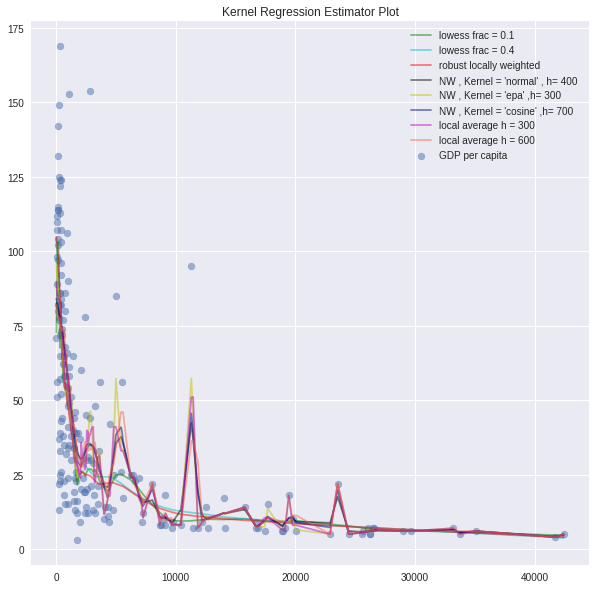

In [8]:
import statsmodels.api as sm
lowess = sm.nonparametric.lowess
from scipy.stats import norm
if __name__ == '__main__':
    import math
    
    y = data2.mortality.values
    x = data2.gdp.values
    
    lowess_stat = lowess(y,x,frac=0.1,it=1)
    lowess_x = list(zip(*lowess_stat))[0]
    lowess_y = list(zip(*lowess_stat))[1]

    lowess_stat = lowess(y,x,frac=0.4,it=1)
    lowess_x1 = list(zip(*lowess_stat))[0]
    lowess_y1 = list(zip(*lowess_stat))[1]

    #f = interp1d(lowess_x, lowess_y, bounds_error=False)
    
    local  = loc_avg(X = x , Y = y ,  h = 300 ) 
    local1  = loc_avg(X = x , Y = y ,  h = 600 ) 


    
    f = 0.25
    yest = lowess2(x, y, f=f, iter=3)
    dataframe = np.concatenate([x[:, np.newaxis ], yest[: , np.newaxis ]] , axis = 1 )
    pred = pd.DataFrame( dataframe, columns = ["x", "yest"]).sort_values(by = ["x"])
    
    
    NW = NWE(X = x ,  Y = y , h = 400  , K = "normal")
    NW1 = NWE(X = x , Y = y , h = 300 , K = "epa" )
    NW2 = NWE(X = x , Y = y , h = 700 , K = "cosine" )
    plt.figure(figsize=(10,10))
    plt.scatter(x, y, label='GDP per capita' , alpha = 0.5)
    plt.plot(lowess_x,lowess_y,'g-', label = "lowess frac = 0.1" , alpha =0.5);
    plt.plot(lowess_x1,lowess_y1,'c-', label = "lowess frac = 0.4" , alpha =0.5);
    plt.plot(pred.x , pred.yest ,"r-" , label = "robust locally weighted" , alpha =0.5)
    plt.plot(NW.x , NW.nw ,"k-" ,label ="NW , Kernel = 'normal' , h= 400 " , alpha = 0.5)
    plt.plot(NW1.x , NW1.nw ,"y-" ,label ="NW , Kernel = 'epa' ,h= 300 " , alpha = 0.5)
    plt.plot(NW2.x , NW2.nw ,"navy" ,label ="NW , Kernel = 'cosine' ,h= 700 " , alpha = 0.5)
    plt.plot(local.x ,local.local ,'m-', label = "local average h = 300 " , alpha =0.5);
    plt.plot(local1.x ,local1.local ,'tomato', label = "local average h = 600 " , alpha = 0.5 );

    plt.title("Kernel Regression Estimator Plot")
    plt.legend()
    plt.show()

    


In [9]:


y = data2.mortality.values

x = data2.gdp.values
h = 300
matrix = norm.pdf( (x[:, None] - x[None, :]) / h  , loc = 0 ,scale = 1) / h
denominator = np.sum( matrix , axis =  1 )
numerator = np.sum(matrix * y , axis = 1 )
m_hat = numerator/denominator    


np.sum( matrix[:, 0]*y / denominator[0] )
print(y[0])
print(np.sum( matrix[:, 0]*y / denominator[0] ))
print(y[0] - m_hat[0])
print(y[0] - np.sum( matrix[:, 0]*y / denominator[0] ))

"""
차이가 없는 것을 확인했다 왜 다른지 모르겠음 
"""


model = nparam.KernelReg(endog=[y],
                          exog=[x], 
                         var_type='c', bw='cv_ls')


model.fit()
print(model.bw)

71.0
85.4223884273563
-14.422388427356267
-14.422388427356296
[726.0998122]


#  Local_avg Optimal H

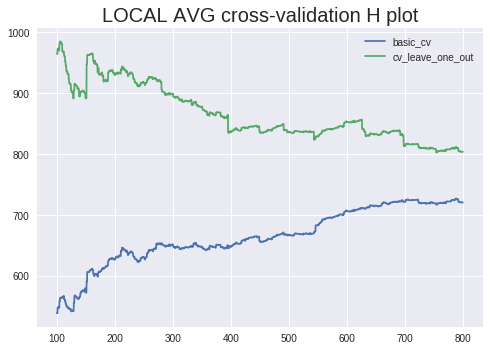

basci_cv  / optimal h = 100.0  loss = 539.0556389971202  
cv_leave_one_out / optimal h = 755.1775887943973  loss = 802.8490864374347  
[726.0998122]


In [10]:
y = data2.mortality.values
x = data2.gdp.values
    
method2 = "local_avg"
grid_h = np.linspace(100 , 800 , 2000)
save = []
save2 = []
for i in grid_h :
    save.append(CV(X= x , Y = y , h = i , method =method2))
    save2.append(BASIC_CV(X= x , Y = y , h = i , method =method2))
plt.plot( grid_h , save2 , label ="basic_cv")
plt.plot( grid_h , save , label ="cv_leave_one_out")
plt.title( "LOCAL AVG cross-validation H plot" , fontsize = 20 )
plt.legend()
plt.show()


save2_index = np.where(save2  ==  np.min(save2))[0]
print("basci_cv  / optimal h = {}  loss = {}  ".format( grid_h[save2_index][0] , np.min(save2)) )

save=np.asarray(save)
save = save[np.isfinite(save)]

save_index = np.where(save  ==  np.min(save))[0]
print("cv_leave_one_out / optimal h = {}  loss = {}  ".format( grid_h[save_index][0] , np.min(save)) )
model = nparam.KernelReg(endog=[y],
                          exog=[x], 
                         var_type='c', bw='cv_ls')


model.fit()
print(model.bw)
model_bw = model.bw


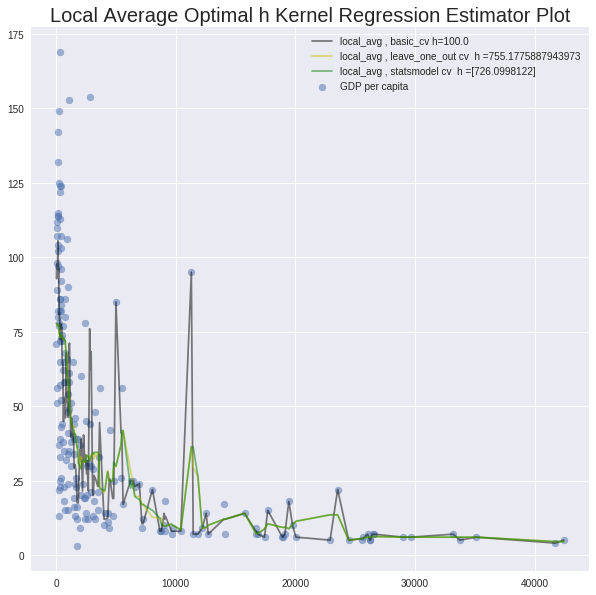

In [11]:
if __name__ == '__main__':
    import math
    
    y = data2.mortality.values
    x = data2.gdp.values
        
    
    local1 = loc_avg(X = x , Y = y , h = grid_h[save2_index][0] )
    local2 = loc_avg(X = x , Y = y , h = grid_h[save_index][0] )
    local3 = loc_avg(X = x , Y = y , h = model_bw )
    
    plt.figure(figsize=(10,10))
    plt.scatter(x, y, label='GDP per capita' , alpha = 0.5)
    plt.plot(local1.x , local1.local ,"k-" ,label ="local_avg , basic_cv h={}".format(grid_h[save2_index][0]) , alpha = 0.5)
    plt.plot(local2.x , local2.local ,"y-" ,label ="local_avg , leave_one_out cv  h ={}".format(grid_h[save_index][0]) , alpha = 0.5)
    plt.plot(local3.x , local3.local ,"g-" ,label ="local_avg , statsmodel cv  h ={}".format(model_bw) , alpha = 0.5)
    plt.title("Local Average Optimal h Kernel Regression Estimator Plot" , fontsize = 20 )
    plt.legend()
    plt.show()



# Method : Nadaraya wastion  CV(h)
* Kernel = "epa" , "cosine" , "normal"
* bandwidth = (100 ,1500 , 2000)
* Multiprocessing 으로 Loop 돌리기

In [13]:
%%time


slice_size = 500

grid_h = np.linspace(100 , 2000 , slice_size)
kernel = ["epa","cosine","normal"]
a = [ tuple( [i , j] ) for i in kernel for j in grid_h] 
import multiprocessing
blank = list()

def two_loop_multi( i = None , j = None) :
    method2 = "nw"
    y = data2.mortality.values
    x = data2.gdp.values
    BASIC_CV_ = BASIC_CV(X= x , Y = y , h = j , method =method2 , kernel = i )
    CV_  = CV(X= x , Y = y , h = j , method =method2 , kernel = i )
    CV2_ = CV2(X= x , Y = y , h = j , method =method2 , kernel = i )
    GCV_ = GCV(X= x , Y = y , h = j , method =method2 , kernel = i )
    return [BASIC_CV_ , CV_ , CV2_ , GCV_ ]

p = multiprocessing.Pool(processes = 2 )
blank.append(p.starmap(two_loop_multi , a ) )
p.close()

CPU times: user 52.8 ms, sys: 19.8 ms, total: 72.6 ms
Wall time: 33 s


cv(h) 의 최소 bandwidth
basic_cv e:  [{'epa': array([100.])}, {'cosine': array([100.])}, {'normal': array([100.])}]
cv f:  [{'epa': array([926.25250501])}, {'cosine': array([926.25250501])}, {'normal': array([328.45691383])}]
cv2 g:  [{'epa': array([100.])}, {'cosine': array([100.])}, {'normal': array([100.])}]
gcv h:  [{'epa': array([1234.66933868])}, {'cosine': array([1280.36072144])}, {'normal': array([598.79759519])}]
model [726.0998122]


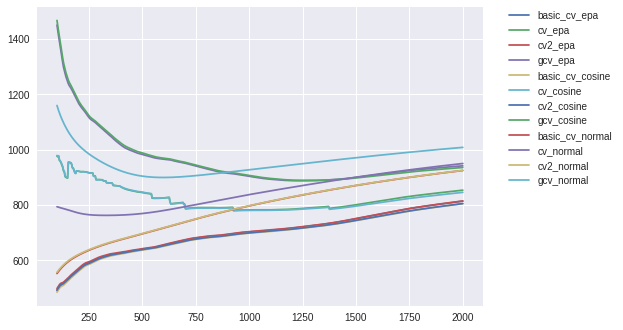

In [14]:
a , b, c, d = [] , [] , [] , []
for x in blank[0] :
    a.append(x[0])
    b.append(x[1])
    c.append(x[2])
    d.append(x[3])

e ,f ,g ,h = [],[],[],[]
kernel = ["epa","cosine","normal"]
for j , i in enumerate(np.arange(0, len(a), slice_size )) :
    plt.plot( grid_h , a[i:(i+slice_size)] , label =str("basic_cv_"+kernel[j]))
    plt.plot( grid_h , b[i:(i+slice_size)] , label =str("cv_"+kernel[j]))
    plt.plot( grid_h , c[i:(i+slice_size)] , label =str("cv2_"+kernel[j]))
    plt.plot( grid_h , d[i:(i+slice_size)] , label =str("gcv_"+kernel[j]))
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    ##
    d1 = np.array(a[i:(i+slice_size)])
    mask = ~np.isnan(d1)
    if len(a[i:(i+slice_size)]) == np.sum(~mask) :
        e.append({kernel[j] : []})
    else :
        e.append({kernel[j] : grid_h[np.where(d1 == np.min(d1[~np.isnan(d1)]) )]})
    ##
    d1 = np.array(b[i:(i+slice_size)])
    mask = ~np.isnan(d1)
    
    if len(b[i:(i+slice_size)]) == np.sum(~mask) :
        f.append({kernel[j] : []})
    else :
        f.append({kernel[j] : grid_h[np.where(d1 == np.min(d1[~np.isnan(d1)]) )]})
    
    ##
    d1 = np.array(c[i:(i+slice_size)])
    mask = ~np.isnan(d1)
    
    if len(c[i:(i+slice_size)]) == np.sum(~mask) :
        g.append({kernel[j] : []})
    else :
        g.append({kernel[j] : grid_h[np.where(d1 == np.min(d1[~np.isnan(d1)]) )]})
    
    
    ##
    d1 = np.array(d[i:(i+slice_size)])
    mask = ~np.isnan(d1)
    if len(d[i:(i+slice_size)]) == np.sum(~mask) :
        h.append({kernel[j] : []})
    else :
        h.append({ kernel[j] : grid_h[np.where(d1 == np.min(d1[~np.isnan(d1)]) )]})
    
    
print("cv(h) 의 최소 bandwidth")
print("basic_cv e: " , e)
print("cv f: " , f)
print("cv2 g: " , g)
print("gcv h: " , h)
y = data2.mortality.values
x = data2.gdp.values
model = nparam.KernelReg(endog=[y],
                          exog=[x], 
                         var_type='c', bw='cv_ls')


model.fit()
print("model" , model.bw)
model_bw = model.bw

## 추정된 값으로 다시 NW 그림 그리기  Kernel = Epanichnikov

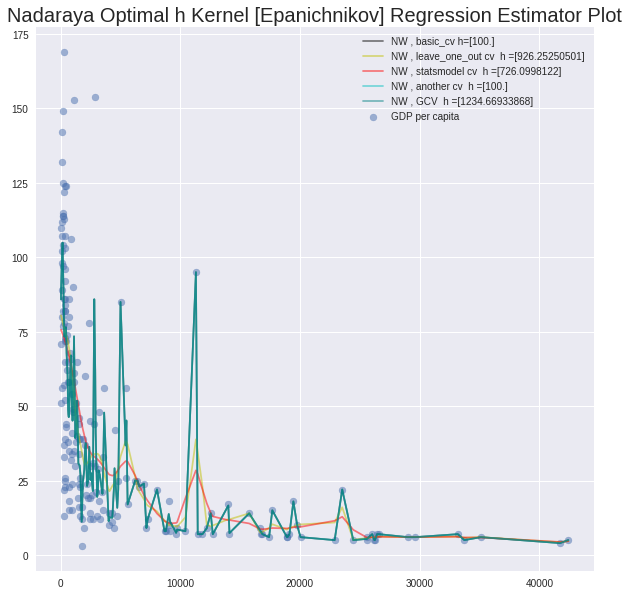

In [17]:

if __name__ == '__main__':
    import math
    
    y = data2.mortality.values
    x = data2.gdp.values
        
    
    NW = NWE(X = x , Y = y ,  h = list(e[0].values() )[0]  , K = "epa")
    NW1 = NWE(X = x , Y = y , h = list(f[0].values() )[0] , K = "epa")
    NW2 = NWE(X = x , Y = y , h = model_bw )
    NW3 = NWE(X = x , Y = y , h = list(g[0].values() )[0] , K = "epa")
    NW4 = NWE(X = x , Y = y , h = list(h[0].values() )[0] , K = "epa")
    plt.figure(figsize=(10,10))
    plt.scatter(x, y, label='GDP per capita' , alpha = 0.5)
    plt.plot(NW.x , NW.nw ,"k-" ,label ="NW , basic_cv h={}".format( list(e[0].values() )[0]) , alpha = 0.5)
    plt.plot(NW1.x , NW1.nw ,"y-" ,label ="NW , leave_one_out cv  h ={}".format(list(f[0].values() )[0] ) , alpha = 0.5)
    plt.plot(NW2.x , NW2.nw ,"r-" ,label ="NW , statsmodel cv  h ={}".format(model_bw) , alpha = 0.5)
    plt.plot(NW3.x , NW3.nw ,"c-" ,label ="NW , another cv  h ={}".format(list(g[0].values() )[0]) , alpha = 0.5)
    plt.plot(NW3.x , NW3.nw ,"teal" ,label ="NW , GCV  h ={}".format(list(h[0].values() )[0]) , alpha = 0.5)
    plt.title("Nadaraya Optimal h Kernel [Epanichnikov] Regression Estimator Plot" , fontsize= 20 )
    plt.legend()
    plt.show()


## 추정된 값으로 다시 NW 그림 그리기  Kernel = Cosine

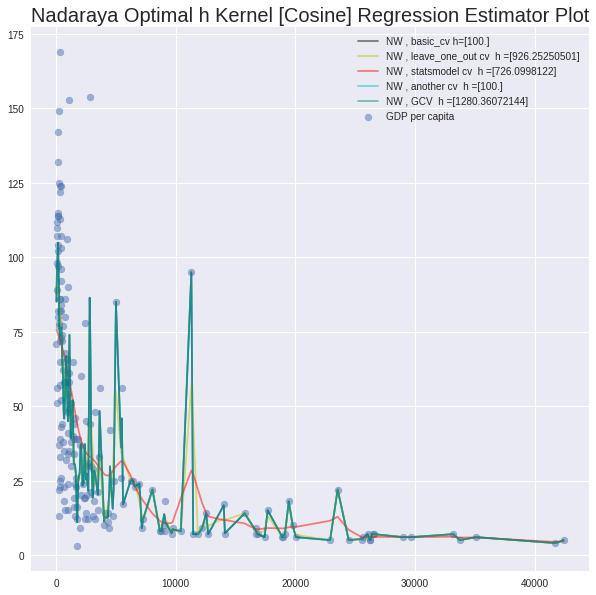

In [18]:

if __name__ == '__main__':
    import math
    
    y = data2.mortality.values
    x = data2.gdp.values
        
    
    NW = NWE(X = x , Y = y ,  h = list(e[2].values() )[0] , K = "cosine")
    NW1 = NWE(X = x , Y = y , h = list(f[2].values() )[0] , K = "cosine")
    NW2 = NWE(X = x , Y = y , h = model_bw )
    NW3 = NWE(X = x , Y = y , h = list(g[2].values() )[0] , K = "cosine")
    NW4 = NWE(X = x , Y = y , h = list(h[2].values() )[0] , K = "cosine")
    plt.figure(figsize=(10,10))
    plt.scatter(x, y, label='GDP per capita' , alpha = 0.5)
    plt.plot(NW.x , NW.nw ,"k-" ,label ="NW , basic_cv h={}".format( list(e[1].values() )[0]) , alpha = 0.5)
    plt.plot(NW1.x , NW1.nw ,"y-" ,label ="NW , leave_one_out cv  h ={}".format(list(f[1].values() )[0] ) , alpha = 0.5)
    plt.plot(NW2.x , NW2.nw ,"r-" ,label ="NW , statsmodel cv  h ={}".format(model_bw) , alpha = 0.5)
    plt.plot(NW3.x , NW3.nw ,"c-" ,label ="NW , another cv  h ={}".format(list(g[1].values() )[0]) , alpha = 0.5)
    plt.plot(NW3.x , NW3.nw ,"teal" ,label ="NW , GCV  h ={}".format(list(h[1].values() )[0]) , alpha = 0.5)
    plt.title("Nadaraya Optimal h Kernel [Cosine] Regression Estimator Plot" , fontsize= 20 )
    plt.legend()
    plt.show()


## 추정된 값으로 다시 NW 그림 그리기  Kernel = Gaussian

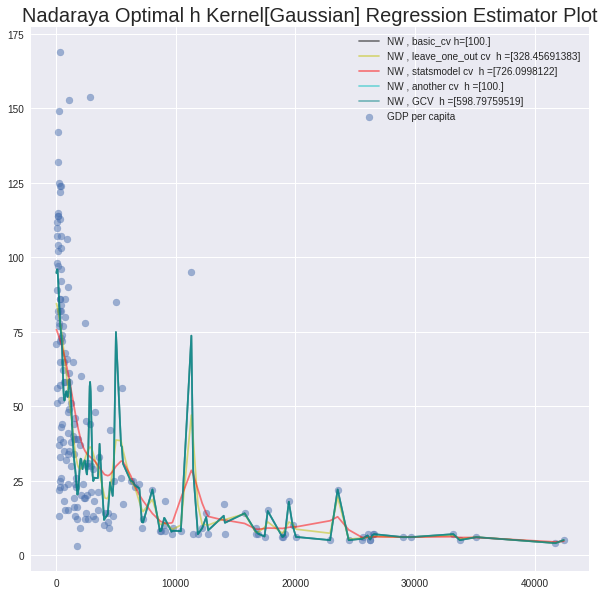

In [20]:

if __name__ == '__main__':
    import math
    
    y = data2.mortality.values
    x = data2.gdp.values
        
    
    NW = NWE(X = x , Y = y ,  h = list(e[2].values() )[0] )
    NW1 = NWE(X = x , Y = y , h = list(f[2].values() )[0] )
    NW2 = NWE(X = x , Y = y , h = model_bw )
    NW3 = NWE(X = x , Y = y , h = list(g[2].values() )[0] )
    NW4 = NWE(X = x , Y = y , h = list(h[2].values() )[0] )
    plt.figure(figsize=(10,10))
    plt.scatter(x, y, label='GDP per capita' , alpha = 0.5)
    plt.plot(NW.x , NW.nw ,"k-" ,label ="NW , basic_cv h={}".format( list(e[2].values() )[0]) , alpha = 0.5)
    plt.plot(NW1.x , NW1.nw ,"y-" ,label ="NW , leave_one_out cv  h ={}".format(list(f[2].values() )[0] ) , alpha = 0.5)
    plt.plot(NW2.x , NW2.nw ,"r-" ,label ="NW , statsmodel cv  h ={}".format(model_bw) , alpha = 0.5)
    plt.plot(NW3.x , NW3.nw ,"c-" ,label ="NW , another cv  h ={}".format(list(g[2].values() )[0]) , alpha = 0.5)
    plt.plot(NW3.x , NW3.nw ,"teal" ,label ="NW , GCV  h ={}".format(list(h[2].values() )[0]) , alpha = 0.5)
    plt.title("Nadaraya Optimal h Kernel[Gaussian] Regression Estimator Plot" , fontsize= 20 )
    plt.legend()
    plt.show()



## Comment
* nadaraya wastion 이 local weight average 보다 좀 더 outlier 에 민감하게 작용하는 것 같다. 
* lowess 은 smooth 하게 선이그어지려하지만 nw 은 h 에 따라서 데이터에 더 민감하게 반응한다.
* lowess 에서 데이터를 어디까지 볼껀지에 따라 그림이 달라지는데 좀 더 많은 데이터를 보게 할수록 완만해지는 경향이 있다.

# [CMD DATA] Consider power as response variable and Multipole as covariate

* Fit a Model based the first 400 observations :
   Make a Scatter plot of the data.
   
   Consider Nadaraya-Waston estimator.
   
   Using CV(h) score to choose to h.
   
   Present your estimate
   
* Repeat the procedure above , but fot the whole data set.

* Multipole (다중극): 
    * 쌍극자를 두개 병렬(竝列)시키면 4중극자, 4중극자를 두 개 병렬시키면 8중극자가 정의된다.
    
    따라서 2중극자{=0, 1, 2, …)를 두 개 늘어 놓으면 2 중극자가 정의되고 이들의 집합을 다중극 또는 다극자라고 한다.
    
 
 * Measure error :
    * power  - 	multiploe
    
 * CL : the angular power spectrum

In [21]:

data = pd.read_fwf("./CMB.txt")
data = data.loc[ : , ["power" , "multiploe"] ]
#sample_size = 400 
#random = np.random.choice(np.arange(len(data)) , sample_size , replace = False )
data3 = data.iloc[ 0:400 , :  ].reset_index()
data3.head()

,index,power,multiploe
0,0,762.6369,759.2556
1,1,608.1737,604.1475
2,2,503.9580,499.6186
3,3,432.1765,427.6281
4,4,380.1810,375.4400


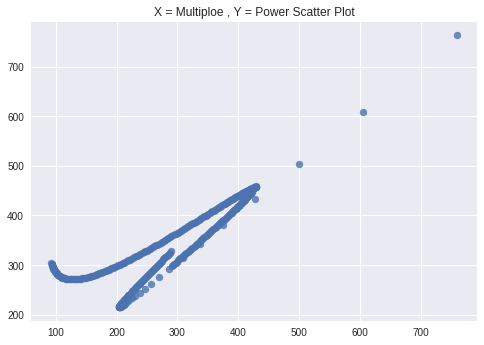

In [22]:

plt.scatter( data3.multiploe,  data3.power , label='GDP per capita' ,alpha =0.8) 
plt.title("X = Multiploe , Y = Power Scatter Plot")
plt.show()

## Nadaraya Waston 방법으로 CV(h) 그리기
* Kernel
    * epa
    * cosine
    * normal

In [23]:
%%time


slice_size = 500
method2 = "nw"

grid_h = np.linspace(1 , 50 , slice_size)
kernel = ["epa","cosine","normal"]
a = [ tuple( [i , j] ) for i in kernel for j in grid_h] 
import multiprocessing
blank = list()

def two_loop_multi( i = None , j = None) :
    method2 = "nw"
    x = data3.multiploe.values
    y = data3.power.values
    BASIC_CV_ = BASIC_CV(X= x , Y = y , h = j , method =method2 , kernel = i )
    CV_  = CV(X= x , Y = y , h = j , method =method2 , kernel = i )
    CV2_ = CV2(X= x , Y = y , h = j , method =method2 , kernel = i )
    GCV_ = GCV(X= x , Y = y , h = j , method =method2 , kernel = i )
    return [BASIC_CV_ , CV_ , CV2_ , GCV_ ]

p = multiprocessing.Pool(processes = 2 )
blank.append(p.starmap(two_loop_multi , a ) )
p.close()


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


CPU times: user 126 ms, sys: 55.3 ms, total: 182 ms
Wall time: 1min 25s


cv(h) 의 최소 bandwidth
basic_cv e:  [{'epa': array([1.])}, {'cosine': array([1.])}, {'normal': array([1.])}]
cv f:  [{'epa': array([13.2745491])}, {'cosine': array([13.37274549])}, {'normal': array([6.79358717])}]
cv2 g:  [{'epa': array([15.9258517])}, {'cosine': array([16.12224449])}, {'normal': array([7.97194389])}]
gcv h:  [{'epa': array([13.37274549])}, {'cosine': array([13.76553106])}, {'normal': array([7.18637275])}]
model [30.2662261]


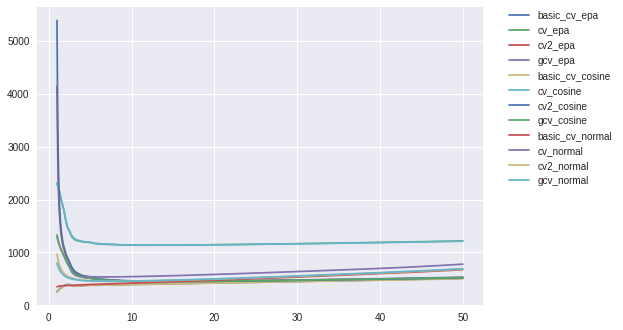

In [24]:
a , b, c, d = [] , [] , [] , []
for x in blank[0] :
    a.append(x[0])
    b.append(x[1])
    c.append(x[2])
    d.append(x[3])

e ,f ,g ,h = [],[],[],[]
kernel = ["epa","cosine","normal"]
for j , i in enumerate(np.arange(0, len(a), slice_size )) :
    plt.plot( grid_h , a[i:(i+slice_size)] , label =str("basic_cv_"+kernel[j]))
    plt.plot( grid_h , b[i:(i+slice_size)] , label =str("cv_"+kernel[j]))
    plt.plot( grid_h , c[i:(i+slice_size)] , label =str("cv2_"+kernel[j]))
    plt.plot( grid_h , d[i:(i+slice_size)] , label =str("gcv_"+kernel[j]))
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    ##
    d1 = np.array(a[i:(i+slice_size)])
    mask = ~np.isnan(d1)
    if len(a[i:(i+slice_size)]) == np.sum(~mask) :
        e.append({kernel[j] : []})
    else :
        e.append({kernel[j] : grid_h[np.where(d1 == np.min(d1[~np.isnan(d1)]) )]})
    ##
    d1 = np.array(b[i:(i+slice_size)])
    mask = ~np.isnan(d1)
    
    if len(b[i:(i+slice_size)]) == np.sum(~mask) :
        f.append({kernel[j] : []})
    else :
        f.append({kernel[j] : grid_h[np.where(d1 == np.min(d1[~np.isnan(d1)]) )]})
    
    ##
    d1 = np.array(c[i:(i+slice_size)])
    mask = ~np.isnan(d1)
    
    if len(c[i:(i+slice_size)]) == np.sum(~mask) :
        g.append({kernel[j] : []})
    else :
        g.append({kernel[j] : grid_h[np.where(d1 == np.min(d1[~np.isnan(d1)]) )]})
    
    
    ##
    d1 = np.array(d[i:(i+slice_size)])
    mask = ~np.isnan(d1)
    if len(d[i:(i+slice_size)]) == np.sum(~mask) :
        h.append({kernel[j] : []})
    else :
        h.append({ kernel[j] : grid_h[np.where(d1 == np.min(d1[~np.isnan(d1)]) )]})
    
    
print("cv(h) 의 최소 bandwidth")
print("basic_cv e: " , e)
print("cv f: " , f)
print("cv2 g: " , g)
print("gcv h: " , h)
x = data3.multiploe.values
y = data3.power.values
model = nparam.KernelReg(endog=[y],
                          exog=[x], 
                         var_type='c', bw='cv_ls')


model.fit()
print("model" , model.bw)
model_bw = model.bw

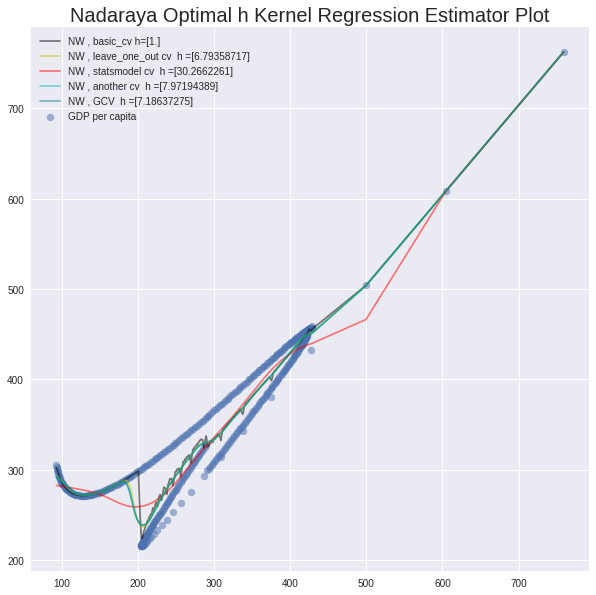

In [25]:

if __name__ == '__main__':
    import math
    
    x = data3.multiploe.values
    y = data3.power.values
        
    
    NW = NWE(X = x , Y = y ,  h = list(e[2].values() )[0] )
    NW1 = NWE(X = x , Y = y , h = list(f[2].values() )[0] )
    NW2 = NWE(X = x , Y = y , h = model_bw )
    NW3 = NWE(X = x , Y = y , h = list(g[2].values() )[0] )
    NW4 = NWE(X = x , Y = y , h = list(h[2].values() )[0] )
    plt.figure(figsize=(10,10))
    plt.scatter(x, y, label='GDP per capita' , alpha = 0.5)
    plt.plot(NW.x , NW.nw ,"k-" ,label ="NW , basic_cv h={}".format( list(e[2].values() )[0]) , alpha = 0.5)
    plt.plot(NW1.x , NW1.nw ,"y-" ,label ="NW , leave_one_out cv  h ={}".format(list(f[2].values() )[0] ) , alpha = 0.5)
    plt.plot(NW2.x , NW2.nw ,"r-" ,label ="NW , statsmodel cv  h ={}".format(model_bw) , alpha = 0.5)
    plt.plot(NW3.x , NW3.nw ,"c-" ,label ="NW , another cv  h ={}".format(list(g[2].values() )[0]) , alpha = 0.5)
    plt.plot(NW3.x , NW3.nw ,"teal" ,label ="NW , GCV  h ={}".format(list(h[2].values() )[0]) , alpha = 0.5)
    plt.title("Nadaraya Optimal h Kernel Regression Estimator Plot" , fontsize= 20 )
    plt.legend()
    plt.show()


# 전체데이터로 다시 시행하기

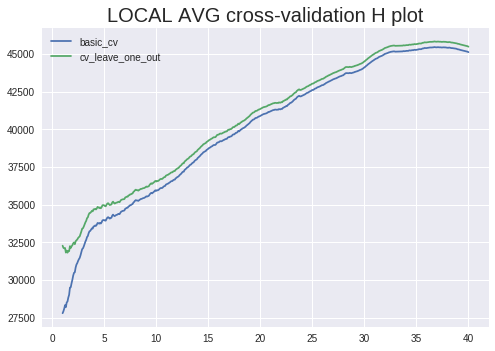

basci_cv  / optimal h = 1.0  loss = 27804.643483825905  
cv_leave_one_out / optimal h = 1.468937875751503  loss = 31819.37551629565  
[30.26566598]


In [26]:
x = data.multiploe.values
y = data.power.values


method2 = "local_avg"
grid_h = np.linspace(1 , 40 , 500)
save = []
save2 = []
for i in grid_h :
    save.append(CV(X= x , Y = y , h = i , method =method2))
    save2.append(BASIC_CV(X= x , Y = y , h = i , method =method2))
plt.plot( grid_h , save2 , label ="basic_cv")
plt.plot( grid_h , save , label ="cv_leave_one_out")
plt.title( "LOCAL AVG cross-validation H plot" , fontsize = 20 )
plt.legend()
plt.show()


save2_index = np.where(save2  ==  np.min(save2))[0]
print("basci_cv  / optimal h = {}  loss = {}  ".format( grid_h[save2_index][0] , np.min(save2)) )

save=np.asarray(save)
save = save[np.isfinite(save)]

save_index = np.where(save  ==  np.min(save))[0]
print("cv_leave_one_out / optimal h = {}  loss = {}  ".format( grid_h[save_index][0] , np.min(save)) )
model = nparam.KernelReg(endog=[y],
                          exog=[x], 
                         var_type='c', bw='cv_ls')


model.fit()
print(model.bw)
model_bw = model.bw



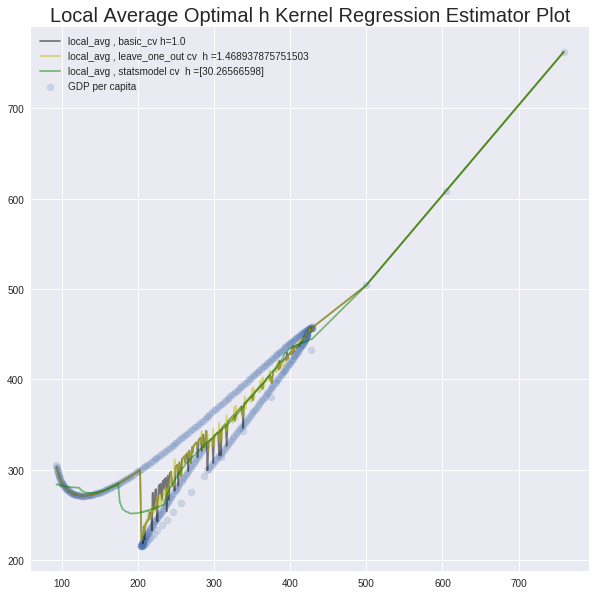

In [43]:
if __name__ == '__main__':
    import math
    
    x = data3.multiploe.values
    y = data3.power.values    
    
    local1 = loc_avg(X = x , Y = y , h = grid_h[save2_index][0] )
    local2 = loc_avg(X = x , Y = y , h = grid_h[save_index][0] )
    local3 = loc_avg(X = x , Y = y , h = model_bw )
    
    plt.figure(figsize=(10,10))
    plt.scatter(x, y, label='GDP per capita' , alpha = 0.2)
    plt.plot(local1.x , local1.local ,"k-" ,label ="local_avg , basic_cv h={}".format(grid_h[save2_index][0]) , alpha = 0.5)
    plt.plot(local2.x , local2.local ,"y-" ,label ="local_avg , leave_one_out cv  h ={}".format(grid_h[save_index][0]) , alpha = 0.5)
    plt.plot(local3.x , local3.local ,"g-" ,label ="local_avg , statsmodel cv  h ={}".format(model_bw) , alpha = 0.5)
    plt.title("Local Average Optimal h Kernel Regression Estimator Plot" , fontsize = 20 )
    plt.legend()
    plt.show()


# 3 
$$ Y_i = m(x_i) + \epsilon_i  \\
where m(x) = x^2 - 2x   \quad  x \in [0,2]  \quad and \quad \epsilon_i  \overset{iid}{\sim}   N(0 , 0.5^2) 
$$

* Simulate one sample {$ (x_i , Y_i  ) , i= 1 , ... , 100 $} \ 
 you can choose $ x_i = \frac{i}{50} $ \
 Fit a Nadaraya-waston estimator to this data
 
* Choose your kernel and h. Estimate MSE( $\hat{m(1)})$) by simulation \
Hint : simulate many samples from the model and use the sample counterpart as the estimator 

* Repeat step 2 for a different h , Compare the results and give your comments 
* Caculate the estimated value of mean integrated squared error (MISE) from 200 repeated samples 

* Extra $MSE = BIAS^2 + Variance $ so you find $ Bias^2  and Variance 200 repeated samples $ 

# 1번 , 3번

In [0]:
x = np.linspace( 0 , 2 , num = 100 )
eps = np.random.normal(loc = 0.0 , scale = 0.5 , size = 100)
m_x = x*x - 2 *x
y = m_x + eps

Text(0.5,1,'$y = x^2 - 2x + \\epsilon$')

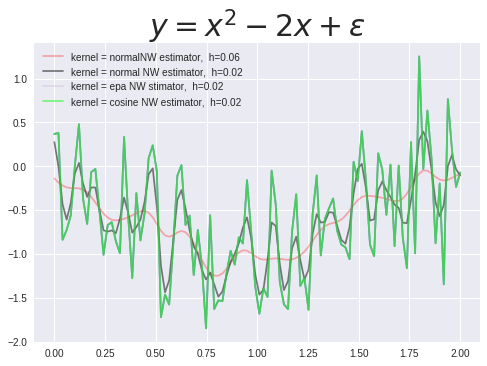

In [37]:
h_size = 0.06
h_size2 = 0.02
plt.plot( x , y )
NW = NWE(X = x , Y = y , h = h_size )
NW2 = NWE(X = x , Y = y , h = h_size2  , K = "normal")
NW3 = NWE(X = x , Y = y , h = h_size2  , K = "epa")
NW4 = NWE(X = x , Y = y , h = h_size2 , K = "cosine")
plt.plot(NW.x , NW.nw ,"r-" ,label ="kernel = normalNW estimator,  h={}".format( h_size ) , alpha = 0.3)
plt.plot(NW2.x , NW2.nw ,"k-" ,label ="kernel = normal NW estimator,  h={}".format( h_size2 ) , alpha = 0.5)
plt.plot(NW3.x , NW3.nw ,"thistle" ,label ="kernel = epa NW stimator,  h={}".format( h_size2 ) , alpha = 0.5)
plt.plot(NW4.x , NW4.nw ,"lime" ,label ="kernel = cosine NW estimator,  h={}".format( h_size2 ) , alpha = 0.5)
plt.legend()
plt.title("$y = x^2 - 2x + \epsilon$" , size= 30)

## Comment 
* h 가 커질수록 완만하게 되는 것을 확인 할 수 있었습니다.

# $MSE(\hat{m}(1))  $ by simulation 샘플링 1000번

* Kernel = Gaussian
* h = 0.01

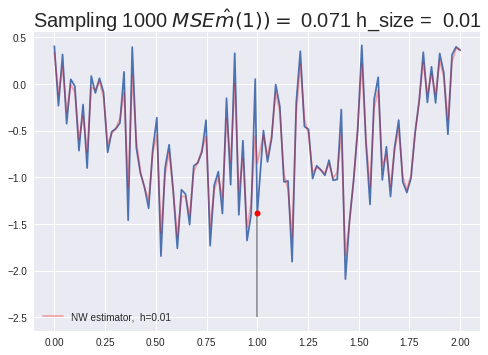

In [38]:
h_size = 0.01

blank = []
for i in range(1000) :
    x = np.linspace( 0 , 2 , num = 100 )
    x[50]=1
    eps = np.random.normal(loc = 0.0 , scale = 0.5 , size = 100)
    m_x = x*x - 2 *x
    y = m_x + eps
    NW = NWE(X = x , Y = y , h = h_size )
    output = np.square(y[50] - NW.nw.values[50])
    blank.append(output)


mse = np.mean(blank)

plt.plot( x , y )
NW = NWE(X = x , Y = y , h = h_size )
plt.plot(NW.x , NW.nw ,"r-" ,label ="NW estimator,  h={}".format( h_size ) , alpha = 0.3)
plt.vlines( x = 1 ,  ymin = -2.5 , ymax = y[50] , colors = "k" , alpha = 0.4)
plt.plot( [1] , y[50] , marker='o', markersize=6, color="red")
plt.legend()
plt.title("Sampling 1000 $MSE \hat{m}(1)) = $ %5.3f h_size = %5.2f" % (mse , h_size ) , fontsize= 20 )
plt.show()


$$ \int E[f(x) - \hat{f(x)}]^2_{dx}  = IMSE \\
E( \int  [f(x) - \hat{f(x)}]^2_{dx} = MISE  \\$$

In [39]:
h_size = 0.01

blank = []
blank2 = []
sampling = 200
for i in range( sampling ) :
    x = np.linspace( 0 , 2 , num = 100 )
    eps = np.random.normal(loc = 0.0 , scale = 0.5 , size = 100)
    m_x = x*x - 2 *x
    y = m_x + eps
    NW = NWE(X = x , Y = y , h = h_size )
    """
    ISE
    """
    output = np.sum( np.square(y - NW.nw.values) )
    blank.append(output)
    """
    MSE
    """
    output2 = np.mean( np.square(y - NW.nw.values) )
    blank2.append(output2)


"""MISE"""
mise = np.mean( blank )
print("Version 1 MISE = " , mise )

"""
합계를 할 때는 샘플링한 수만큼이 아닌 데이터 사이즈 만큼 해줘야 해서 
샘플링 200번 / 데이터 개수 100 개 이므로 2로 나눠줘야한다.
"""
mise2 = np.sum(blank2) / int(sampling / 100 )
print("Version 2 MISE = " , mise2)

Version 1 MISE =  1.560206112628619
Version 2 MISE =  1.5602061126286193


$$ \int E[f(x) - \hat{f(x)}]^2_{dx}  = IMSE \\
E( \int  [f(x) - \hat{f(x)}]^2_{dx} = MISE  \\
\int MSE = \int Var + Bias^2_{dx} == \int E[(\hat{f(x)} - E[\hat{f(x)}])^2] + \int E[\hat{f(x)}-f(x)]^2  $$


어디서 실수인지 모르겠음

In [36]:
h_size = 0.01

var = []
bias = []
mse = []
sampling = 200
for i in range( sampling ) :
    x = np.linspace( 0 , 2 , num = 100 )
    eps = np.random.normal(loc = 0.0 , scale = 0.5 , size = 100)
    m_x = x*x - 2 *x
    y = m_x + eps
    NW = NWE(X = x , Y = y , h = h_size )
    """
    Bias , Var
    """
    VAR   = np.mean( np.square( NW.nw.values - np.mean( NW.nw.values ) ) )
    var.append(VAR)
    
   
    BIAS  = np.square( np.mean( NW.nw.values - y  )  )
    bias.append(BIAS)
    """
    MSE
    """
    output = np.mean( np.square( y - NW.nw.values) )
    mse.append(output)


    
bias = np.sum(bias) / int(sampling / 100 )
var = np.sum(var)  / int(sampling / 100 )
mise = var + bias

print("integrated var + integrated bias => MISE = " , mise )

    
"""
MISE
"""

mise2 = np.sum(mse) / int(sampling / 100 )
print("Version 2 MISE = " , mise2)


integrated var + integrated bias => MISE =  25.108873510799654
Version 2 MISE =  1.5740591145354559


In [37]:
h_size = 0.01

blank = []
for i in range(1000) :
    x = np.linspace( 0 , 2 , num = 100 )
    x[50]=1
    eps = np.random.normal(loc = 0.0 , scale = 0.5 , size = 100)
    m_x = x*x - 2 *x
    y = m_x + eps
    NW = NWE(X = x , Y = y , h = h_size )
    """
    MSE
    """
    output = np.mean( np.square(y - NW.nw.values) )
    blank.append(output)


"""MISE"""
mise = np.sum(blank)
print("MISE = " , mise)

MISE =  16.89827798891952
